# Requests & JSON opdrachten

## Listeria monocytogenes subtypen in de voedingsmiddelenindustrie

Op het [LCAB](https://www.hsleiden.nl/lcab) werken we al een tijdje aan een [project](https://www.hsleiden.nl/actueel/nieuws/lcab/lcab-breidt-onderzoek-naar-voedselveiligheid-uit.html) waarin we *Listeria monocytogenes (L. mono)* besmettingen in de voedingsmiddelenindustrie in kaart brengen. Binnen dit project worden *L. mono* stammen gesequenced door middel van Nanopore sequencing zodat we de fylogenetische verbanden tussen samples kunnen vinden. Verder worden stammen getypeerd aan met bijvoorbeeld [Multi Locus Sequence Typing](https://pubmlst.org/multilocus-sequence-typing).

De data van dit project is beschiknaar via een API, die programmatisch te benaderen is op http://145.97.18.244:8004 (link werk alleen het netwerk van de Hogeschool of via de HSLeiden VPN). De bijbehorende (interactieve) documentatie van de API endpoints kan je vinden op http://145.97.18.244:8004/docs.

**Let op: alle PATCH/POST/DELETE operaties zijn uitgezet op deze API, je kunt dus geen data wijzigen**

### Vraag 1.

Bepaal de top-8 bedrijven met de meeste gesequencede *L. mono* samples. Gebruik daarvoor het `/sequencedata/` endpoint van de API. Toon, voor elk van deze bedrijven, alle MLST `sequence_types` die vaker dan 4 keer voorkomen, in een stacked barplot. 

Een voorbeeld van de verwachte output zie je hieronder (voor de top-4 bedrijven, waarbij het minimale aantal per MLST `sequence_type` op 9 staat).

![image](mlst_stacked_barplot.png)


<Axes: xlabel='sample.bedrijf'>

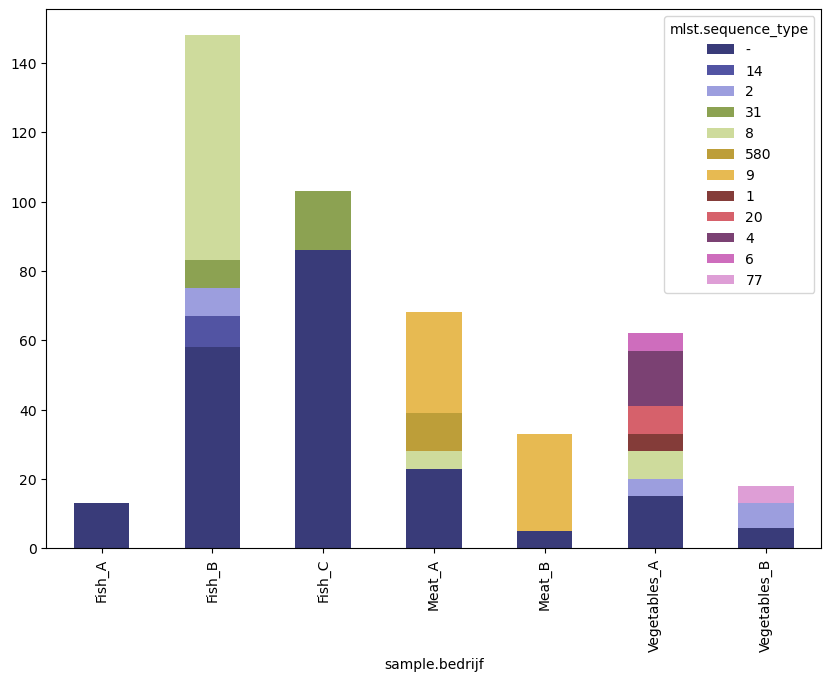

In [1]:
# maak hier vraag 1

import requests
import pandas as pd

listeria_api = 'http://145.97.18.244:8004/{query}'

response = requests.get(listeria_api.format(query="sequencedata/?offset=0&limit=-1"))
seqdata = pd.json_normalize(response.json())
mlst_data = seqdata.filter(items=['mlst.sequence_type', 'sample.bedrijf', 'mlst.md5hash'])
grootste_bedrijven = mlst_data.groupby(['sample.bedrijf']).count()['mlst.sequence_type'].nlargest(8)
mlst_counts = mlst_data[mlst_data['sample.bedrijf'].isin(grootste_bedrijven.index)].groupby(['sample.bedrijf','mlst.sequence_type']).count()
mlst_counts[mlst_counts["mlst.md5hash"] > 4]['mlst.md5hash'].unstack("mlst.sequence_type").plot.bar(stacked=True, figsize=(10,7), colormap="tab20b")

### Vraag 2.

De genomen van de Listeria bacterien zijn in elkaar gezet door middel van een *de novo* assembly van de Nanopore sequence data. Het doel is om het genoom in één continue DNA sequentie te plaatsen. Dit lukt niet altijd, en dan valt de assembly uit elkaar in meerdere zogenaamde contigs.

- Maak een histogram de verdeling van de groottes van *alle* contigs
- Maak een histogram de verdeling van het aantal contigs per sample

Toon deze twee plots naast elkaar. Verdeel de data in beide gevallen over 100 bins.

<Axes: title={'center': 'Number of contigs'}, xlabel='number', ylabel='Frequency'>

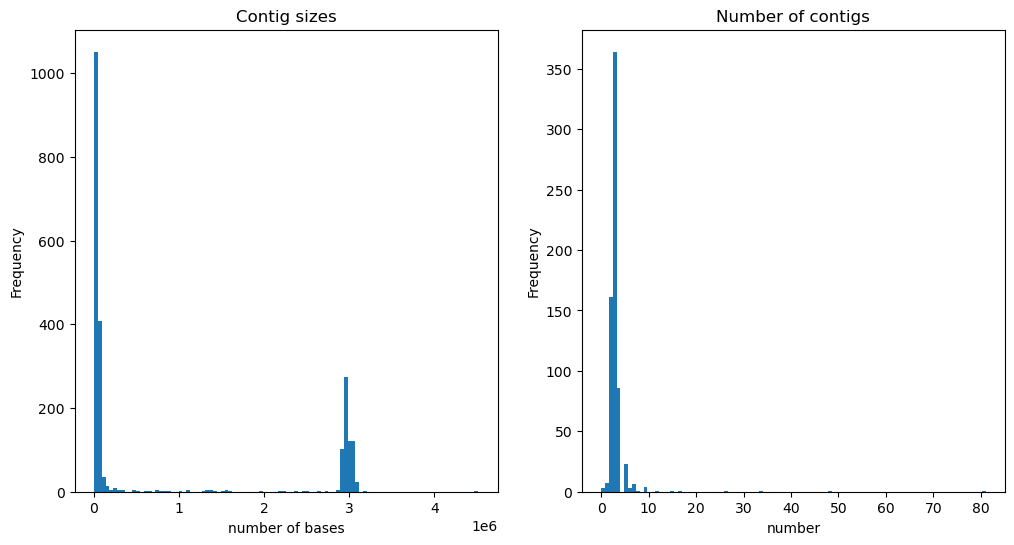

In [2]:
# maak hier vraag 2

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12,6))

seqdata = response.json()
contigs = []
n_contigs = []
for seqdat in seqdata:
    if seqdat.get('assembly', None):
        contigs += [i["length"] for i in seqdat['assembly']['contigs']]
        n_contigs.append(len(seqdat['assembly']['contigs']))
pd.Series(data=contigs).plot.hist(bins=100, ax=ax[0], title="Contig sizes", xlabel="number of bases")
pd.Series(data=n_contigs).plot.hist(bins=100, ax=ax[1], title="Number of contigs", xlabel="number")


### Vraag 3.

Hoeveel `sequencedata` objecten in de database zijn van bedrijf `meat_A` of `fish_B`?

- Gebruik hierbij het API endpoint `http://145.97.18.244:8004/sequencedata`. **Je mag niets toevoegen aan deze string in je request.**
- Maak gebruik van`params`
- Omdat we alleen geinteresseerd zijn in het aantal objecten (en niet de inhoud), zet je de parameter `namesonly` op `True`.


In [3]:
# maak hier vraag 3
api_endpoint = "http://145.97.18.244:8004/sequencedata"

params = {'bedrijf': ['meat_A', 'fish_B'], 'namesonly': True}

len(requests.get(api_endpoint, params=params).json())


262

### Vraag 4.

Welke samples zijn méér dan 1 keer gesequenced? *Hint: bekijk het sequencedata object. Bevat deze sample-informatie?*

In [4]:
# maak hier vraag 4.

ids = [record["samplename"] for record in seqdata]
repeated_ids = {id for id in ids if ids.count(id) > 1}
print(repeated_ids)

{'T0131_1144', 'T0131_1193', 'T0131_1363', 'T0131_1241', 'T0131_1415', 'T0131_1421', 'T0131_1404', 'T0131_1392', 'T0131_1362', 'T0131_1391', 'T0131_1403', 'T0131_1416', 'T0131_1229', 'T0131_1156', 'T0131_1383', 'T0131_1390', 'T0131_1143', 'T0131_1400', 'T0131_1148', 'T0131_1192', 'T0131_1223', 'T0131_1305', 'T0131_1191', 'T0131_1397', 'T0131_1204', 'T0131_1413', 'T0131_1369', 'T0131_1387', 'T0131_1423', 'T0131_1168', 'T0131_1382', 'T0131_1180', 'T0131_1379', 'T0131_1147', 'T0131_1145', 'T0131_1427', 'T0131_1380', 'T0131_1395', 'T0131_1389', 'T0131_1146', 'T0131_1431', 'T0131_1217', 'T0131_1429', 'T0131_1150', 'T0131_1437', 'T0131_1149', 'T0131_1364', 'T0131_1412', 'T0131_1160', 'T0131_1402', 'T0131_1184', 'T0131_1190', 'T0131_1426', 'T0131_1401'}


## De landen API

Op [deze plek](https://restcountries.com/) staat een REST API waarmee je informatie op kan halen over landen.


### Vraag 5. 

Schrijf code die voor een (door de gebruiker bepaalde) [subregio](https://unstats.un.org/unsd/methodology/m49/) bepaalt welk land in die subregio grenst aan de meeste landen. Als resultaat wordt er een string getoond met de subregio, de 3-lettercode van het land met de meeste buurlanden, en de vlaggen van alle buurlanden als emoji. Bijvoorbeeld:

```
Eastern Asia : CHN borders 🇷🇺🇹🇯🇰🇵🇲🇴🇻🇳🇲🇳🇲🇲🇵🇰🇧🇹🇰🇬🇳🇵🇮🇳🇱🇦🇭🇰🇦🇫🇰🇿
```

```
Central America : GTM borders 🇲🇽🇸🇻🇧🇿🇭🇳
```

Een paar opmerkingen:
- Je mag maximaal 2 requests doen
- Als er meerdere landen evenveel buurlanden hebben, neem dan het land waarvan de 3-lettercode alfabetisch het eerste komt.
 
 *Uitdaging voor de programmeur die graag efficient werkt: formuleer je requests op een manier waardoor je alleen maar data ophaalt die je ook daadwerkelijk gaat gebruiken*

In [5]:
# Geef de regio op
target_subregion = 'Western Europe'

# Maak hier vraag 5. 
r = requests.get(f'https://restcountries.com/v3.1/subregion/{target_subregion}')
print(r)
region = r.json()
region.sort(key=lambda country: (1000-len(country.get('borders', [])), country['cca3']))

r = requests.get('https://restcountries.com/v3.1/alpha', params={'codes': region[0]['borders']})
r.status_code
print(target_subregion, ":", region[0]['cca3'], "borders", "".join([i['flag'] for i in r.json()]))

<Response [200]>
Western Europe : DEU borders 🇩🇰🇳🇱🇧🇪🇨🇭🇵🇱🇱🇺🇦🇹🇨🇿🇫🇷
